# **Hate Speech Detection Model**

Link to the data https://github.com/amankharwal/Website-data/blob/master/hate%20speech.rar.

The dataset I will use for the hate speech detection model is called train.  This package includes a list of 31,962 tweets, a corresponding ID and a tag 0 or 1 for each tweet. The particular sentiment we need to detect in this dataset is whether or not the tweet is based on hate speech.

**Data Set Information**

The term hate speech is understood as any verbal, written, or behavioural communication that disparages or uses racial or ethnic slurs against an individual or group because of who they are, such as because of their religion, ethnicity, nationality, race, colour, ancestry, sex, or another identity characteristic. I'll walk you through a Python and machine learning-based hate speech detection model in this article.

Hate Speech Detection is generally a task of sentiment classification. So for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, I will use the Twitter data.

In [1]:
!pip install imblearn
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 4.8 MB/s eta 0:00:00


In [2]:
# Import the necessary libraries

# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

import re
import pickle
from functools import reduce
import math
from time import time

# nltk.download("all")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import plotly.express as px


from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
)

# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings("ignore")

# libraries to be used for preprocessing
import nltk

nltk.download("stopwords")
nltk.download("vader_lexicon")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.tokenize import TweetTokenizer

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Improving visual appearance of graphs
sns.set(rc={"figure.figsize": (13, 10)})

# Ensure all columns are displayed
pd.pandas.set_option("display.max_columns", None)

In [4]:
# Sample method to look at some random tweets present in our dataset
# train = pd.read_csv("/content/train.csv")
train = pd.read_csv("/content/train.csv")

train.sample(10)

,id,label,tweet
17185,17186,0,@user one day to go until the the wedding awa...
18827,18828,0,for when ur but that doesn't stop the pay fr...
17302,17303,0,working with@user to develop your greencommuni...
5243,5244,0,go to and win the new galaxy s7 edge #awesome
2749,2750,0,@user @user @user @user you're a #lonewolf w...
26645,26646,0,twinklatinboys - na: #slut #snapshot #hot #nas...
438,439,0,u can hold a man down for years ...and watch h...
10706,10707,0,so the @user tells all the other players there...
31412,31413,0,#scared #nervous #girlpowerwins! firstâ¦
7507,7508,0,@user @user @user i know how u feel i didn't ...


In [5]:
# Check number of tweets
print("Number of tweets: {}".format(len(train)))

Number of tweets: 31962


In [6]:
# Example of tweet with sentiment
print("Tweet: {}".format(train["tweet"]))
print("Tweet Sentiment: {}".format(train["label"]))

Tweet: 0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object
Tweet Sentiment: 0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64


In [7]:
# Number of positive and negative tweets
print("Number of + tweets: {}".format(train[train["label"] == 0].count()[0]))
print("Number of - tweets: {}".format(train[train["label"] == 1].count()[0]))

Number of + tweets: 29720
Number of - tweets: 2242


# **Data Analysis and Visualization**

In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


**Attribute information**

The train.csv has the following fields:

- Id
- Label (0 or 1)
- Tweet (different random tweets)

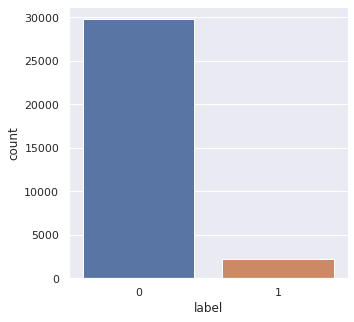

In [9]:
fig = plt.figure(figsize=(5, 5))
sns.countplot(x="label", data=train)

In [10]:
def univariateAnalysis_numeric1(column, nbins):
    print("\nDescription of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    print(train[column].describe(), end=" ")

    print("\nCentral values of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    # Central values
    print("\nMinimum : ", train[column].min(), end=" ")
    print("\nMaximum : ", train[column].max(), end=" ")
    print("\nMean value : ", train[column].mean(), end=" ")
    print("\nMedian value : ", train[column].median(), end=" ")
    print("\nStandard deviation : ", train[column].std(), end=" ")
    print("\nNull values : ", train[column].isnull().any(), end=" ")
    print("\nNull values : ", train[column].isnull().sum().sum(), end=" ")

    print("\nQuartile of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    # Quartiles
    Q1 = train[column].quantile(q=0.25)
    Q3 = train[column].quantile(q=0.75)
    print("1st Quartile (Q1) is: ", Q1)
    print("3st Quartile (Q3) is: ", Q3)
    print("Interquartile range (IQR) is ", stats.iqr(train[column]))

    print("\nOutlier detection from Interquartile range (IQR) " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    L_outliers = Q1 - 1.5 * (Q3 - Q1)
    U_outliers = Q3 + 1.5 * (Q3 - Q1)
    print("\nLower outliers range: ", L_outliers)
    print("\nUpper outliers range: ", U_outliers)
    print(
        "Number of outliers in upper : ",
        train[train[column] > U_outliers][column].count(),
    )
    print(
        "Number of outliers in lower : ",
        train[train[column] < L_outliers][column].count(),
    )
    print(
        "% of Outlier in upper: ",
        round(train[train[column] > U_outliers][column].count() * 100 / len(train)),
        "%",
    )
    print(
        "% of Outlier in lower: ",
        round(train[train[column] < L_outliers][column].count() * 100 / len(train)),
        "%",
    )

    # boxplot
    plt.figure()
    print("\nBoxPlot of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    ax = sns.boxplot(x=train[column])
    plt.show()

    # distplot
    plt.figure()
    print("\ndistplot of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    sns.distplot(train[column])
    plt.show()

    # histogram
    plt.figure()
    print("\nHistogram of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    sns.distplot(train[column], kde=False, color="red")
    plt.show()

    # Plotting mean, median and mode
    plt.figure()
    print("\nHistogram with mean, median and mode of " + column)
    print(
        "----------------------------------------------------------------------------"
    )
    mean = train[column].mean()
    median = train[column].median()
    mode = train[column].mode()

    print("Mean: ", mean, "\nMedian: ", median, "\nMode: ", mode[0])
    plt.hist(train[column], bins=100, color="lightblue")  # Plot the histogram
    plt.axvline(
        mean, color="green", label="Mean"
    )  # Draw lines on the plot for mean median and the two modes we have in GRE Score
    plt.axvline(median, color="blue", label="Median")
    plt.axvline(mode[0], color="red", label="Mode1")
    plt.legend()  # Plot the legend
    plt.show()

    print("\nSkewness of " + column)
    print(
        "----------------------------------------------------------------------------"
    )

    print(train[column].skew())

    fig, (ax1) = plt.subplots(1, 0, figsize=(13, 5))

In [11]:
df_num = train.select_dtypes(include=["float64", "int64"])
lstnumericcolumns = list(df_num.columns.values)
len(lstnumericcolumns)
# df_num.head()

2


Description of id
----------------------------------------------------------------------------
count    31962.000000
mean     15981.500000
std       9226.778988
min          1.000000
25%       7991.250000
50%      15981.500000
75%      23971.750000
max      31962.000000
Name: id, dtype: float64 
Central values of id
----------------------------------------------------------------------------

Minimum :  1 
Maximum :  31962 
Mean value :  15981.5 
Median value :  15981.5 
Standard deviation :  9226.778988357746 
Null values :  False 
Null values :  0 
Quartile of id
----------------------------------------------------------------------------
1st Quartile (Q1) is:  7991.25
3st Quartile (Q3) is:  23971.75
Interquartile range (IQR) is  15980.5

Outlier detection from Interquartile range (IQR) id
----------------------------------------------------------------------------

Lower outliers range:  -15979.5

Upper outliers range:  47942.5
Number of outliers in upper :  0
Number of outliers in

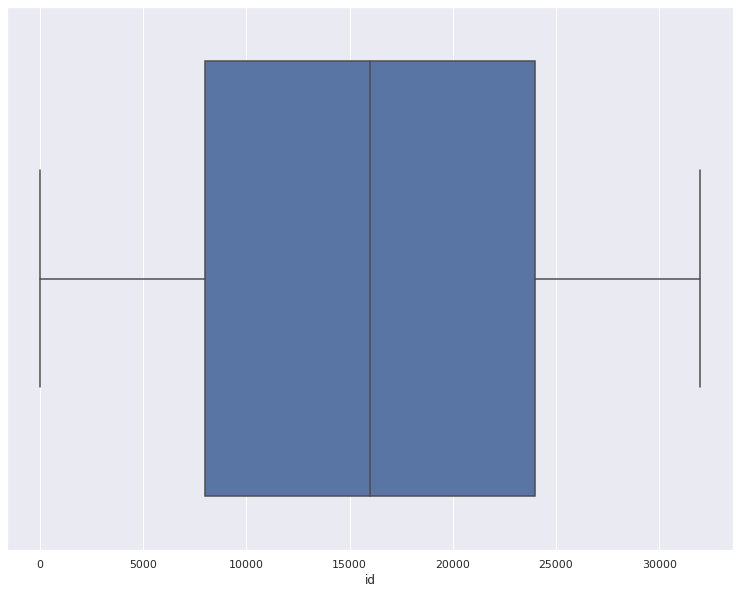


distplot of id
----------------------------------------------------------------------------


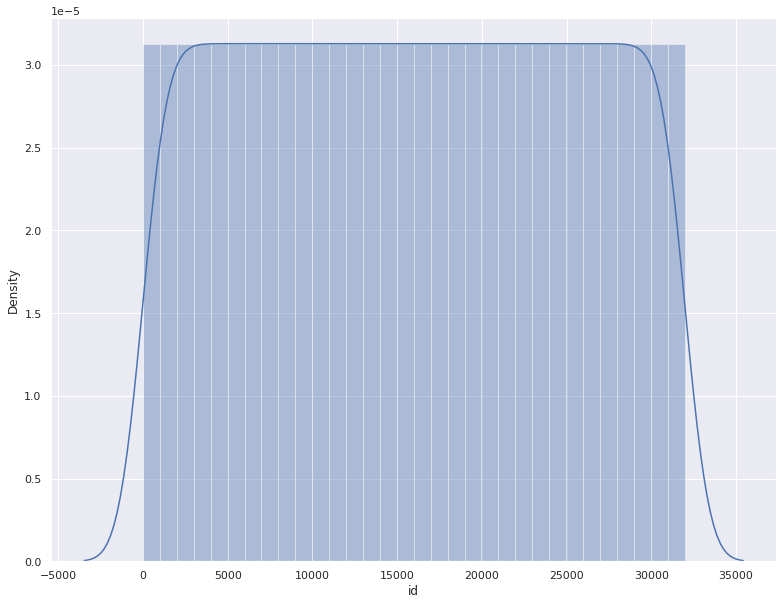


Histogram of id
----------------------------------------------------------------------------


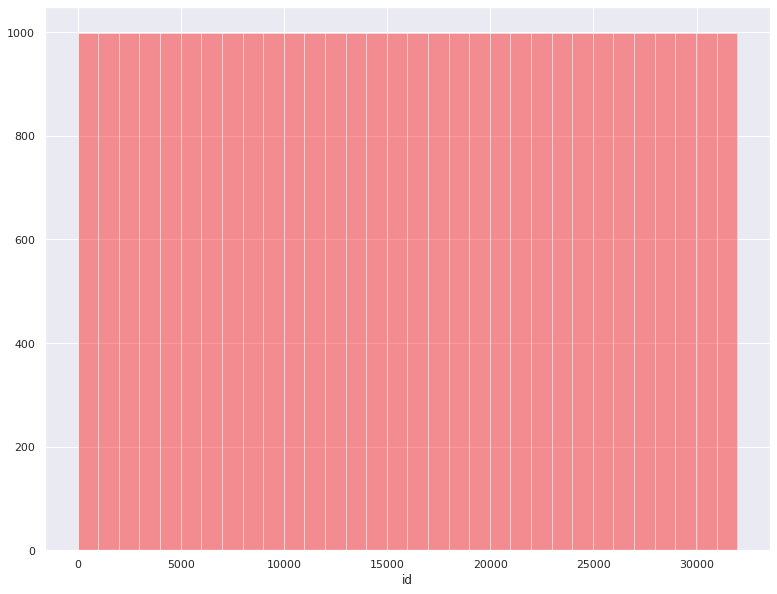


Histogram with mean, median and mode of id
----------------------------------------------------------------------------
Mean:  15981.5 
Median:  15981.5 
Mode:  1


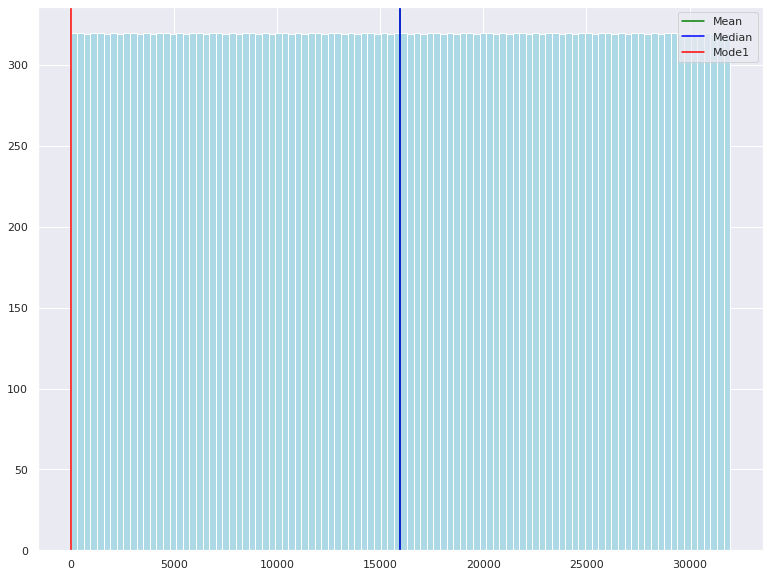


Skewness of id
----------------------------------------------------------------------------
0.0

Description of label
----------------------------------------------------------------------------
count    31962.000000
mean         0.070146
std          0.255397
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64 
Central values of label
----------------------------------------------------------------------------

Minimum :  0 
Maximum :  1 
Mean value :  0.07014579813528565 
Median value :  0.0 
Standard deviation :  0.2553965659892679 
Null values :  False 
Null values :  0 
Quartile of label
----------------------------------------------------------------------------
1st Quartile (Q1) is:  0.0
3st Quartile (Q3) is:  0.0
Interquartile range (IQR) is  0.0

Outlier detection from Interquartile range (IQR) label
----------------------------------------------------------------------------

Lower outliers

<Figure size 936x360 with 0 Axes>

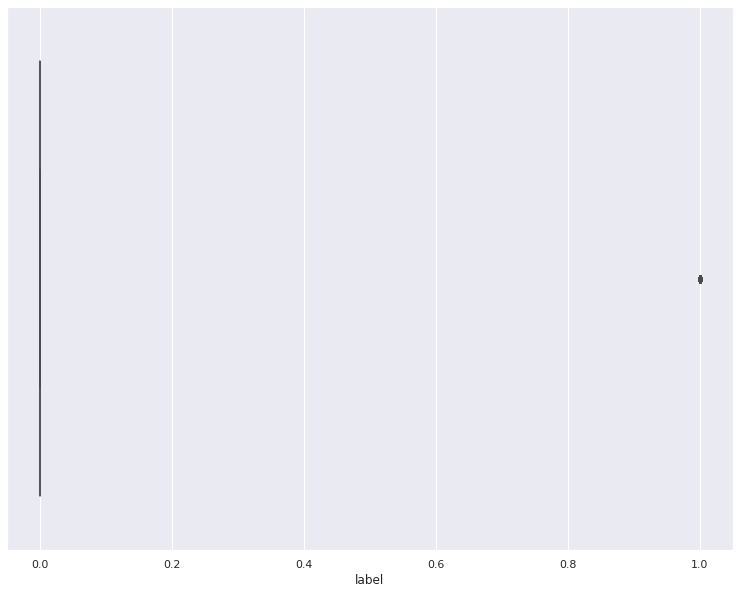


distplot of label
----------------------------------------------------------------------------


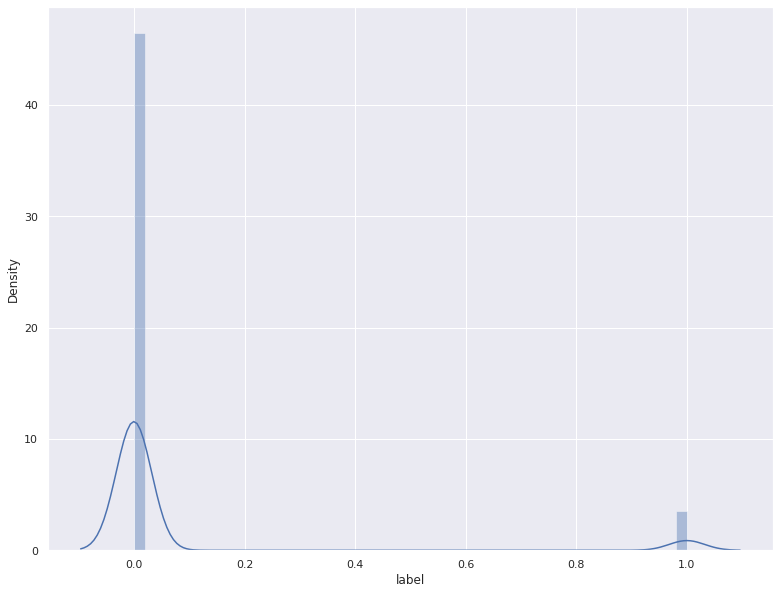


Histogram of label
----------------------------------------------------------------------------


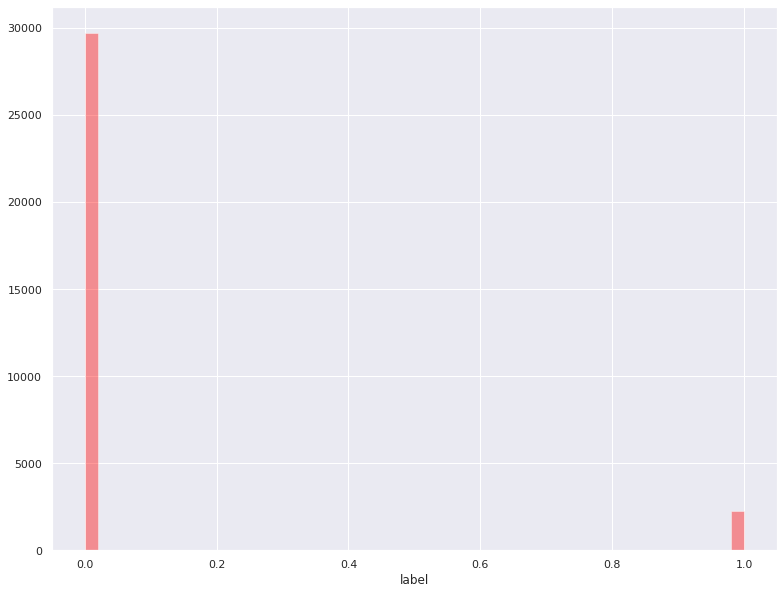


Histogram with mean, median and mode of label
----------------------------------------------------------------------------
Mean:  0.07014579813528565 
Median:  0.0 
Mode:  0


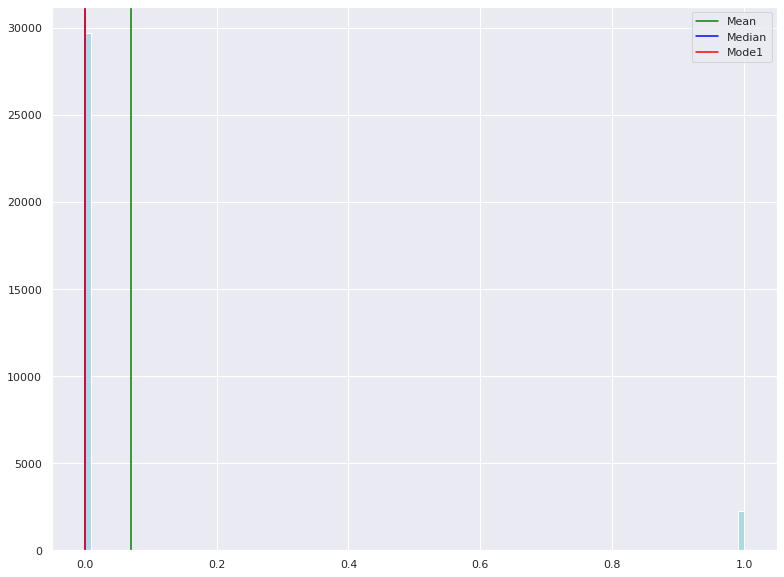


Skewness of label
----------------------------------------------------------------------------
3.366381217473261


<Figure size 936x360 with 0 Axes>

In [12]:
for x in lstnumericcolumns:
    univariateAnalysis_numeric1(x, 20)



**Wordclouds**

*   The wordclouds package is very useful to get a quick overview of most recurrent words in the dataset
*   what are the words most often present in positive tweets


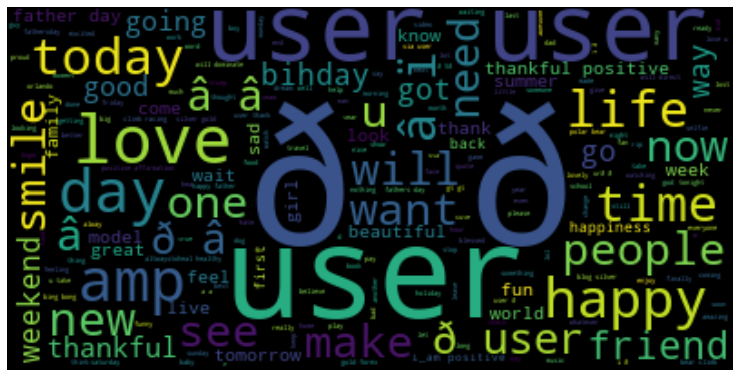

In [13]:
# visual representation of words that appear most in positive tweets
pos_tweets = train[train["label"] == 0]
txt = " ".join(tweet.lower() for tweet in pos_tweets["tweet"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

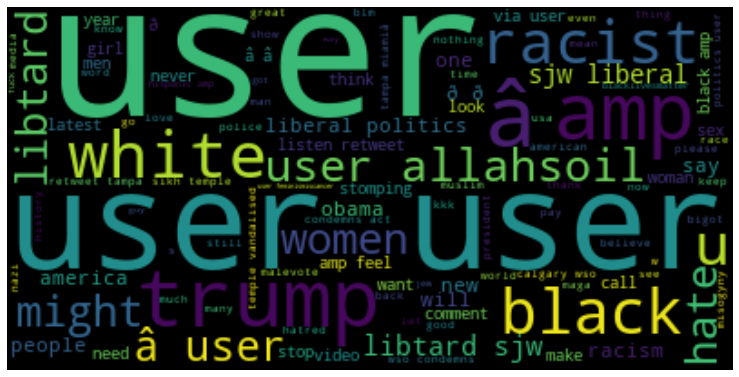

In [14]:
# visual representation of words that appear most in negative tweets
pos_tweets = train[train["label"] == 1]
txt = " ".join(tweet.lower() for tweet in pos_tweets["tweet"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# **Text Preprocessing**

**Review Preprocessing**

Preprocessing will include 3 Steps Pipeline 1 1.create a pipeline that is used to extract Clean text which will be used for rating labeling. Remove html strip text remove stopwords replace special characters filter out uncommon symbols combine whitespace lower text stemming(snowball stemmer) pipeline 2 Strip html strip text



**Stop words**

Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. In NLP and text mining applications, stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.

Below we'll use wordcloud to visualize stop words and thereafter remove them.

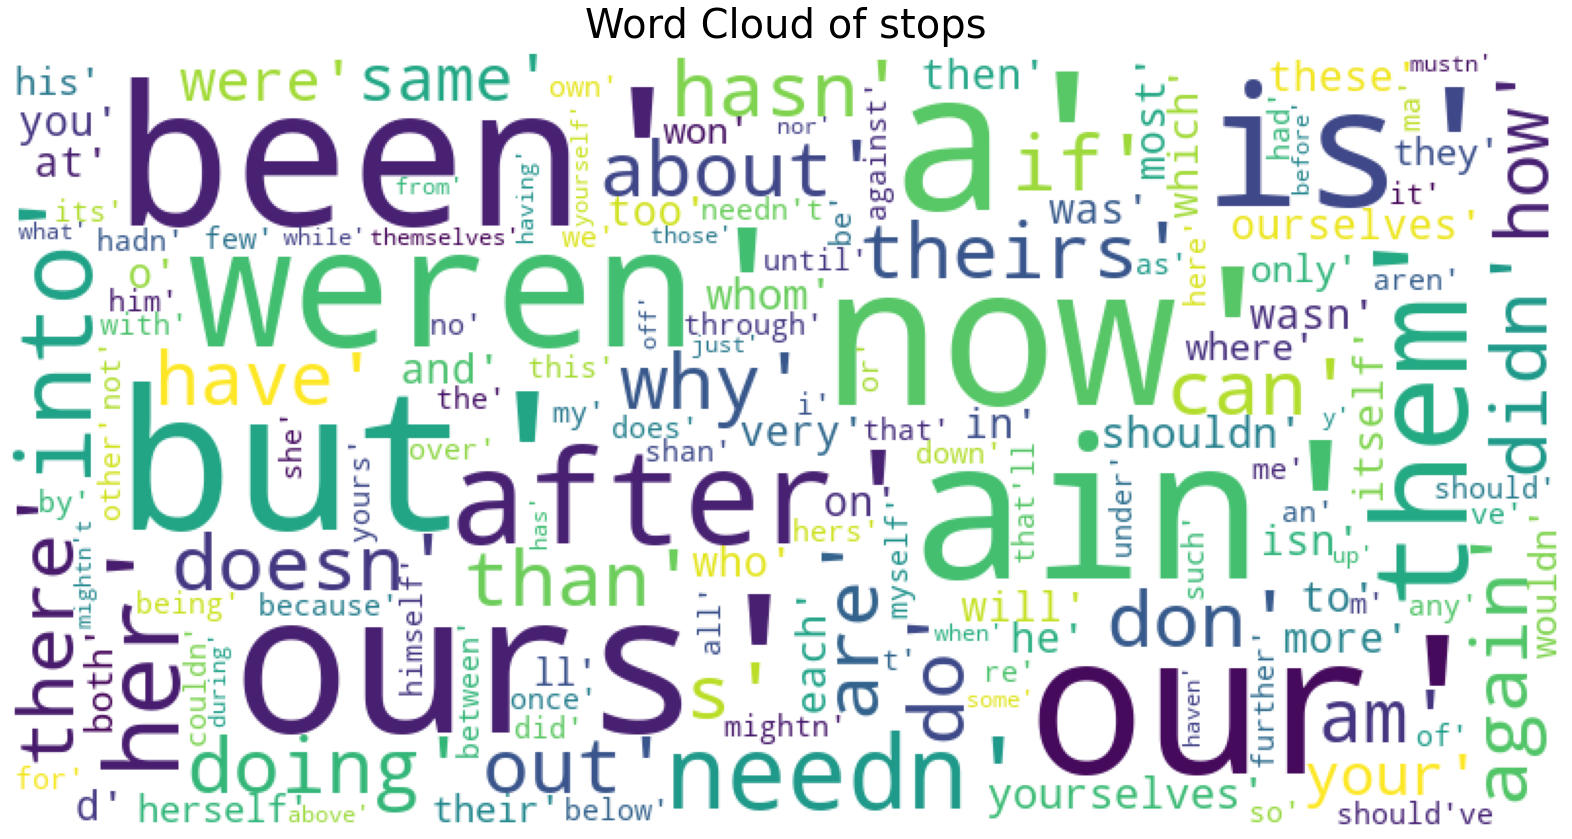

In [15]:
# check the words used as stopwords.In this case we will use word-cloud
def plot_wordcloud(
    text,
    mask=None,
    max_words=200,
    max_font_size=100,
    figure_size=(22.0, 15.0),
    title=None,
    title_size=40,
    image_color=False,
):
    stopwords = set(STOPWORDS)
    more_stopwords = {"one", "br", "Po", "th", "sayi", "fo", "Unknown"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=max_words,
        max_font_size=max_font_size,
        random_state=42,
        width=800,
        height=400,
        mask=mask,
    )
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={"size": title_size, "verticalalignment": "bottom"})
    else:
        plt.imshow(wordcloud)
        plt.title(
            title,
            fontdict={
                "size": title_size,
                "color": "black",
                "verticalalignment": "bottom",
            },
        )
    plt.axis("off")
    plt.tight_layout()


stops = set(stopwords.words("english"))
plot_wordcloud(stops, title="Word Cloud of stops")

In [16]:
# remove words that include not
stops = set(stopwords.words("english"))

neg_list = [
    "aren't",
    "couldn't",
    "didn't",
    "doesn't",
    "don't",
    "hadn't",
    "hasn't",
    "haven't",
    "isn't",
    "mightn't",
    "mustn't",
    "needn't",
    "no",
    "nor",
    "not",
    "shan't",
    "shouldn't",
    "wasn't",
    "weren't",
    "wouldn't",
]
for i in neg_list:
    stops.remove(i)

In [17]:
#preprocessing pipeline 1

class CleanTweet(BaseEstimator, TransformerMixin):
     # Remove HTML tags 
    def strip_html(self, text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

     #strip text(removes left orright spacing including carriage return)
    
    def strip_text(self, text):
        return text.strip()
    
     # Remove English Stop words
    def stopwords(self, text):
        stop_words = set(nltk.corpus.stopwords.words('english'))     
        stop_words_no_neg = stop_words - set(neg_list)
        text = ' '.join([word for word in text.split() if word not in stop_words_no_neg ])
        return text 
   #replace special characters
    def replace_special_characters(self, text):
        return re.compile('[/(){}\[\]\|@,;:.#+_?!"$%&@~]\t').sub('', text)
    #filter uncommon symbols
    def filter_out_uncommon_symbols(self, text):
        return re.compile('[^0-9a-zA-Z ]').sub(' ', text)
    #combine whitespaces(removes multiple whitespaces)
    def combine_whitespace(self, text):
        return re.compile(r"\s+").sub(" ", text).strip()
    #lower the text (to lowercase)
    def lower(self, text):
        return text.lower()
    #stemming
    def stemming(self, text):
        stemmer = SnowballStemmer('english')
        text = ' '.join(stemmer.stem(token) for token in nltk.word_tokenize(text))
        return text
    def fit(self, X, y=None, **fit_params):
        return self
    #pipeline 1
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.strip_html)\
        .apply(self.strip_text)\
        .apply(self.stopwords)\
        .apply(self.replace_special_characters)\
        .apply(self.filter_out_uncommon_symbols)\
        .apply(self.combine_whitespace)\
        .apply(self.lower)\
        .apply(self.stemming)
        return clean_X
    #pipeline 2
    def transform_vader(self, X, **transform_params):
        clean_X = X.apply(self.strip_html)\
        .apply(self.strip_text)
        return clean_X


In [18]:
%%time
ct = CleanTweet()
train['clean_tweet'] = ct.fit(train.tweet).transform(train.tweet)

CPU times: user 19.2 s, sys: 1.22 s, total: 20.4 s
Wall time: 27.5 s


In [19]:
%%time
ct = CleanTweet()
train['VADER_clean_text'] = ct.fit(train.tweet).transform_vader(train.tweet)

CPU times: user 1.63 s, sys: 74 ms, total: 1.71 s
Wall time: 1.68 s


In [20]:
# choose the columns to remain
train = train[["label", "clean_tweet"]]

In [21]:
train["clean_tweet"] = train["clean_tweet"].str.replace("user", "")
train

,label,clean_tweet
0,0,father dysfunct selfish drag kid dysfunct run
1,0,thank lyft credit can t use caus don t offer...
2,0,bihday majesti
3,0,model love u take u time ur
4,0,factsguid societi motiv
...,...,...
31957,0,ate isz youuu
31958,0,see nina turner airwav tri wrap mantl genuin h...
31959,0,listen sad song monday morn otw work sad
31960,1,sikh templ vandalis calgari wso condemn act


In [22]:
a = train['clean_tweet'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
dff = pd.DataFrame(word_dist.most_common(), 
                    columns=['Word', 'Frequency'])
dff['Word_Count'] = dff.Word.apply(len)
dff[:5]


,Word,Frequency,Word_Count
0,love,3240,4
1,day,2852,3
2,s,2413,1
3,t,2253,1
4,happi,2105,5


In [23]:
fig = px.histogram(
    dff[:20],
    x="Word",
    y="Frequency",
    height=300,
    title="Most common 20 words in tweets",
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.update_yaxes(showgrid=False),
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(hovertemplate=None)
fig.update_layout(
    margin=dict(t=100, b=0, l=70, r=40),
    hovermode="x unified",
    xaxis_tickangle=360,
    xaxis_title=" ",
    yaxis_title=" ",
    plot_bgcolor="#2d3035",
    paper_bgcolor="#2d3035",
    title_font=dict(size=25, color="#a5a7ab", family="Lato, sans-serif"),
    font=dict(color="#8a8d93"),
)

In [24]:
fig = px.bar(
    dff.tail(10),
    x="Word",
    y="Frequency",
    height=300,
    title="Least common 10 words in tweets",
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig.update_yaxes(showgrid=False),
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(hovertemplate=None)
fig.update_layout(
    margin=dict(t=100, b=0, l=70, r=40),
    hovermode="x unified",
    xaxis_title=" ",
    yaxis_title=" ",
    plot_bgcolor="#2d3035",
    paper_bgcolor="#2d3035",
    title_font=dict(size=25, color="#a5a7ab", family="Lato, sans-serif"),
    font=dict(color="#8a8d93"),
)

# **Sentiment Intensity Analyser/ Opinion mining ( VADER Based)**





In [25]:
#Sentiment Analysis
SIA = SentimentIntensityAnalyzer()
train["clean_tweet"]= train["clean_tweet"].astype(str)

# Applying Model, Variable Creation
train['Polarity Score']=train["clean_tweet"].apply(lambda x:SIA.polarity_scores(x)['compound'])
#train['Neutral Score']=train["clean_tweet"].apply(lambda x:SIA.polarity_scores(x)['neu'])
train['Negative Score']=train["clean_tweet"].apply(lambda x:SIA.polarity_scores(x)['neg'])
train['Positive Score']=train["clean_tweet"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
train['Sentiment']=''
train.loc[train['Polarity Score']>=0,'Sentiment']='1'
#train.loc[train['Polarity Score']==0,'Sentiment']='neutral'
train.loc[train['Polarity Score']<0,'Sentiment']='0'
train[:5]




,label,clean_tweet,Polarity Score,Negative Score,Positive Score,Sentiment
0,0,father dysfunct selfish drag kid dysfunct run,-0.6124,0.5,0.000,0
1,0,thank lyft credit can t use caus don t offer...,0.6249,0.0,0.317,1
2,0,bihday majesti,0.0000,0.0,0.000,1
3,0,model love u take u time ur,0.6369,0.0,0.512,1
4,0,factsguid societi motiv,0.0000,0.0,0.000,1


In [26]:
fig_pie = px.pie(
    train,
    names="Sentiment",
    title="Distribution of Labels",
    height=250,
    hole=0.7,
    color_discrete_sequence=px.colors.qualitative.T10,
)
fig_pie.update_traces(textfont=dict(color="#fff"))
fig_pie.update_layout(
    margin=dict(t=80, b=30, l=70, r=40),
    plot_bgcolor="#2d3035",
    paper_bgcolor="#2d3035",
    title_font=dict(size=25, color="#a5a7ab", family="Lato, sans-serif"),
    font=dict(color="#8a8d93"),
    legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=0.8),
)

# **Data Pre-processing**

In [27]:
# Number of positive and negative tweets after balancing the data
print("Number of + tweets: {}".format(train[train["label"] == 0].count()[0]))
print("Number of - tweets: {}".format(train[train["label"] == 1].count()[0]))

Number of + tweets: 29720
Number of - tweets: 2242


In [28]:
# Checking for duplicate data
print(train.duplicated().sum())
train[train.duplicated()]

2704


,label,clean_tweet,Polarity Score,Negative Score,Positive Score,Sentiment
46,0,model love u take u time ur,0.6369,0.000,0.512,1
96,0,model love u take u time ur,0.6369,0.000,0.512,1
117,0,model love u take u time ur,0.6369,0.000,0.512,1
162,0,model love u take u time ur,0.6369,0.000,0.512,1
218,0,model love u take u time ur,0.6369,0.000,0.512,1
...,...,...,...,...,...,...
31905,0,love,0.6369,0.000,1.000,1
31925,0,afternoon,0.0000,0.000,0.000,1
31930,1,feminismiscanc feminismisterror feminismmuktb...,0.0000,0.000,0.000,1
31951,0,i ve post new blog secondlif lone neko,-0.2732,0.259,0.000,0


In [29]:
# Drop duplicates
train.drop_duplicates(inplace=True)

# Number of positive and negative tweets after balancing the data
print("Number of + tweets: {}".format(train[train["label"] == 0].count()[0]))
print("Number of - tweets: {}".format(train[train["label"] == 1].count()[0]))

Number of + tweets: 27278
Number of - tweets: 1980


Text(0.5, 1.0, 'Distribution of Labels')

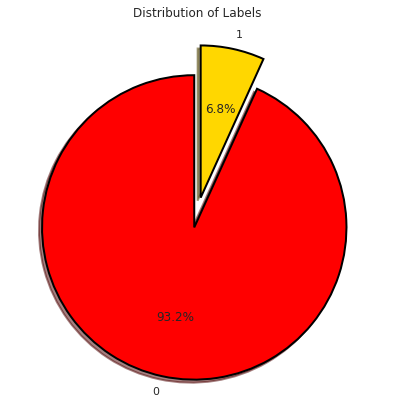

In [30]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = train['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Labels')


From the above visual, we can see that t the tweets regarding hate speeches are comparatively lesser than others, so this is a situation of an unbalanced data.


If we will fit this data to train our hate speech detection model, then the model will not generalize any hate speech because the data with context to the hate speech is very less than the positive ones. So in this situation, we will need to prepare the data to fit properly in our model.

First let's train the model with the data as it is before resampling, then after upsampling

#**Text pre processing & Modelling**



In [31]:
# display first ten tweets
train.head(10)

,label,clean_tweet,Polarity Score,Negative Score,Positive Score,Sentiment
0,0,father dysfunct selfish drag kid dysfunct run,-0.6124,0.500,0.000,0
1,0,thank lyft credit can t use caus don t offer...,0.6249,0.000,0.317,1
2,0,bihday majesti,0.0000,0.000,0.000,1
3,0,model love u take u time ur,0.6369,0.000,0.512,1
4,0,factsguid societi motiv,0.0000,0.000,0.000,1
5,0,2 2 huge fan fare big talk leav chao pay dispu...,0.4939,0.093,0.307,1
6,0,camp tomorrow danni,0.0000,0.000,0.000,1
7,0,next school year year exam can t think school ...,-0.5719,0.222,0.000,0
8,0,won love land allin cav champion cleveland cle...,0.9153,0.000,0.702,1
9,0,welcom i m gr8,0.5719,0.000,0.787,1


In [32]:
# convert dataframe to a list one for Clean tweets and one for labels
X = train["clean_tweet"]
Y = train["label"]

print(X[:3])
print(Y[:3])

0        father dysfunct selfish drag kid dysfunct run
1      thank lyft credit can t use caus don t offer...
2                                       bihday majesti
Name: clean_tweet, dtype: object
0    0
1    0
2    0
Name: label, dtype: int64


Next we split the data into training and testing sets **before** anything else in order to avoid overfitting and model leakage

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, train_size=0.70, stratify=Y
)

In [34]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("\n")
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("\n")
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))
print("\n")
print("Train propotion: {:.0%}".format(len(X_train) / (len(X_train) + len(X_test))))

Shape of Training set :  (20480,)
Shape of test set :  (8778,)


Percentage of classes in training set:
0    0.932324
1    0.067676
Name: label, dtype: float64


Percentage of classes in test set:
0    0.932331
1    0.067669
Name: label, dtype: float64


Train propotion: 70%


In [35]:
from random import randint
import random

In [36]:
#create a fit_tfidf function used to build the TF-IDF vectorizer with the data

tokenizer = TweetTokenizer()

def fit_tfidf(tokens):
  tf_vect = TfidfVectorizer(preprocessor = lambda x: x,
                            ngram_range=(1, 3), 
                            tokenizer=tokenizer.tokenize
                           )
  tf_vect.fit(X)
  return tf_vect


In [37]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [38]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [39]:
# Transform X_train and X_test data by using the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

### Logistic Regression

In [40]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=1)

In [41]:
# Calculating different metrics on train set

lr = LogisticRegression(random_state=1)
lr.fit(X_train_tf, y_train)

log_reg_model_train_perf = model_performance_classification_sklearn(
    lr, X_train_tf, y_train
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.935791,0.05267,0.973333,0.099932


In [42]:
# Calculating different metrics on test set
log_reg_model_val_perf = model_performance_classification_sklearn(lr, X_test_tf, y_test)
print("Testing performance:")
log_reg_model_val_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.934267,0.030303,0.947368,0.058728


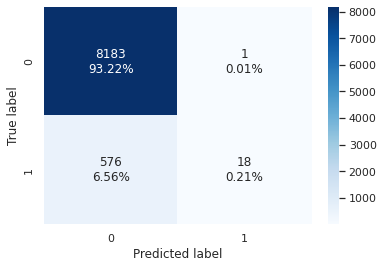

In [43]:
# creating confusion matrix
confusion_matrix_sklearn(lr, X_test_tf, y_test)

The model has a rvery low recall, and as we can see in the classification matrix above, it hasn't been able to predict positive labels well enough even though it has an accuracy of 93%. This is because the data is highly imbalanced and therefore we need to do upsampling before training the model.

Upsampling is only done on the training set, and not on the testing set in order to avoid overfitting

### Logistic Regression on Oversampled data

In [44]:
print("Before UpSampling, counts of label '+': {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of label '-': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train_tf, y_train)


print("After UpSampling, counts of label '+': {}".format(sum(y_train_over == 1)))
print("After UpSampling, counts of label '-': {} \n".format(sum(y_train_over == 0)))


print("After UpSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After UpSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before UpSampling, counts of label '+': 1386
Before UpSampling, counts of label '-': 19094 

After UpSampling, counts of label '+': 19094
After UpSampling, counts of label '-': 19094 

After UpSampling, the shape of train_X: (38188, 367604)
After UpSampling, the shape of train_y: (38188,) 



In [45]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with training set
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(random_state=1)

In [46]:
# Calculating different metrics on train set
log_reg_over_train_perf = model_performance_classification_sklearn(
    log_reg_over, X_train_over, y_train_over
)
print("Training performance:")
log_reg_over_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.973421,0.954645,0.991892,0.972912


In [47]:
# Calculating different metrics on test set
log_reg_over_val_perf = model_performance_classification_sklearn(
    log_reg_over, X_test_tf, y_test
)
print("Testing performance:")
log_reg_over_val_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.954432,0.594276,0.689453,0.638336


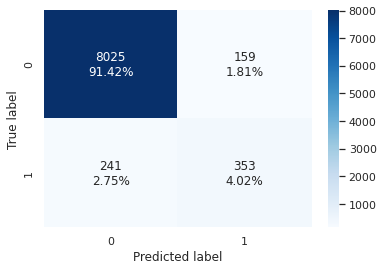

In [48]:
# creating confusion matrix
confusion_matrix_sklearn(log_reg_over, X_test_tf, y_test)

In [49]:
y_pred = log_reg_over.predict(X_test_tf)

# print(confusion_matrix(y_test, y_pred))
# print("\n")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8184
           1       0.69      0.59      0.64       594

    accuracy                           0.95      8778
   macro avg       0.83      0.79      0.81      8778
weighted avg       0.95      0.95      0.95      8778



**Precision:** Of all tweets we've predicted as negative, what fraction actually negative?

**Recall:** Of all tweets that are actually negative, what fraction did we correctly detect as negative?

The model has a considerable performance, but let's see if we can get better accuracy from other models!

In the next step we'll train different models to see whether we can get better performance

### Other Models

In [50]:
scorer = metrics.make_scorer(metrics.f1_score)

In [51]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1, n_jobs=-1)))
models.append(("Bagging", BaggingClassifier(random_state=1, n_jobs=-1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, n_jobs=-1)))
# models.append(("GBM", GradientBoostingClassifier(random_state=1)))
# models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(
    ("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss", n_jobs=-1))
)
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model,
        X=X_train_over,
        y=y_train_over,
        scoring=scorer,
        cv=kfold,
        n_jobs=-1,
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Testing Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = f1_score(y_test, model.predict(X_test_tf))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.9637493960493705
Bagging: 0.9706431829764828
Random forest: 0.9928742810920328
Xgboost: 0.8386920873391347
dtree: 0.9717819410051458

Testing Performance:

Logistic regression: 0.6383363471971067
Bagging: 0.571656050955414
Random forest: 0.5293413173652695
Xgboost: 0.4678150498640073
dtree: 0.5648604269293924


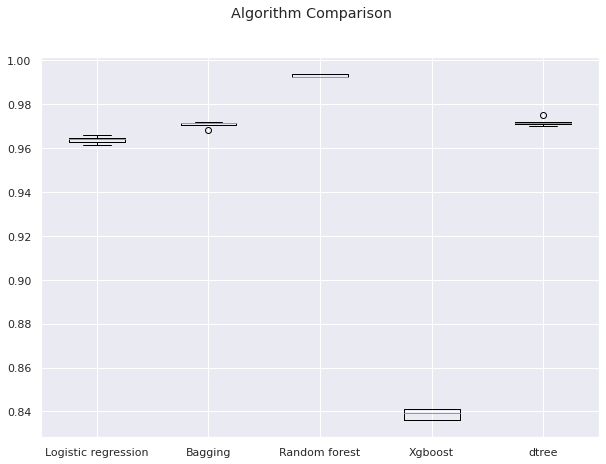

In [52]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Tuning Random Forest on Oversampled data

In [53]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    max_features="sqrt",
    random_state=1,
    max_samples=0.6,
    n_estimators=700,
    min_samples_leaf=1,
)

tuned_rf2.fit(X_train_over, y_train_over)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       max_samples=0.6, n_estimators=700, n_jobs=-1,
                       random_state=1)

In [54]:
rf2_train_perf = model_performance_classification_sklearn(
    tuned_rf2, X_train_over, y_train_over
)

print("Training performance:")
rf2_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999948,0.999948,0.999948,0.999948


In [55]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_test_tf, y_test)

print("Testing performance:")
rf2_val_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.955343,0.378788,0.907258,0.534442


In [56]:
print(classification_report(y_test, tuned_rf2.predict(X_test_tf)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8184
           1       0.91      0.38      0.53       594

    accuracy                           0.96      8778
   macro avg       0.93      0.69      0.76      8778
weighted avg       0.95      0.96      0.95      8778



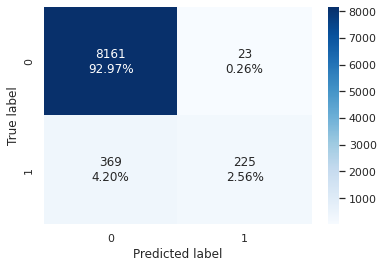

In [57]:
confusion_matrix_sklearn(tuned_rf2, X_test_tf, y_test)

### Tuning XGB Classifier on Oversampled data

In [58]:
# Creating new pipeline with best parameters
xgb_tuned = XGBClassifier(
    eval_metric="logloss",
    n_jobs=-1,
    n_estimators=700,
    scale_pos_weight=3,
    subsample=0.9,
    learning_rate=0.2,
    gamma=7,
    colsample_bytree=0.9,
    colsample_bylevel=1,
    random_state=1,
)

xgb_tuned.fit(X_train_over, y_train_over)

XGBClassifier(colsample_bytree=0.9, eval_metric='logloss', gamma=7,
              learning_rate=0.2, n_estimators=700, n_jobs=-1, random_state=1,
              scale_pos_weight=3, subsample=0.9)

In [59]:
xgb_tuned_model_train_perf = model_performance_classification_sklearn(
    xgb_tuned, X_train_over, y_train_over
)

print("Training performance:")
xgb_tuned_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.970698,0.986226,0.95652,0.971146


In [60]:
xgb_tuned_model_test_perf = model_performance_classification_sklearn(
    xgb_tuned, X_test_tf, y_test
)

print("Testing performance:")
xgb_tuned_model_test_perf

Testing performance:


,Accuracy,Recall,Precision,F1
0,0.924242,0.661616,0.458576,0.541695


In [61]:
print(classification_report(y_test, xgb_tuned.predict(X_test_tf)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8184
           1       0.46      0.66      0.54       594

    accuracy                           0.92      8778
   macro avg       0.72      0.80      0.75      8778
weighted avg       0.94      0.92      0.93      8778



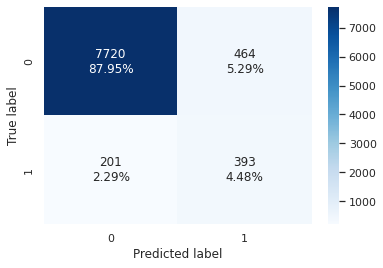

In [62]:
confusion_matrix_sklearn(xgb_tuned, X_test_tf, y_test)

In [63]:
# Validation performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_val_perf.T,
        log_reg_over_val_perf.T,
        rf2_val_perf.T,
        xgb_tuned_model_test_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression",
    "Logistic Regression with Oversampled data",
    "Tuned Random Forest with Oversampled data",
    "Tuned XGB Classifier with Oversampled data",
]
print("Testing performance comparison:")
models_train_comp_df.style.highlight_max(axis=1)

Testing performance comparison:


,Logistic Regression,Logistic Regression with Oversampled data,Tuned Random Forest with Oversampled data,Tuned XGB Classifier with Oversampled data
Accuracy,0.934267,0.954432,0.955343,0.924242
Recall,0.030303,0.594276,0.378788,0.661616
Precision,0.947368,0.689453,0.907258,0.458576
F1,0.058728,0.638336,0.534442,0.541695


* **Logistic regression model on Oversampled data** has given a generalized performance with the highest F1 score on validation data, and it also has the second best recall after XGB, so we choose it as our best model.
